## Exercise 5.1

The Jupyter notebook for this chapter, **[chap05.ipynb](../chap05.ipynb)**, includes an interaction that lets you compute autocorrelations for different lags.

Use this interaction to estimate the pitch of the vocal chirp for a few different start times.

In [2]:
import numpy as np
import thinkdsp_exercises as td
import os

In [3]:
if not os.path.exists("../28042__bcjordan__voicedownbew.wav"):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/28042__bcjordan__voicedownbew.wav

In [4]:
def serial_corr(wave, lag=1):
    N = len(wave)
    y1 = wave.ys[lag:]
    y2 = wave.ys[:N-lag]
    corr = np.corrcoef(y1, y2)[0, 1]
    return corr

In [5]:
def autocorr(wave):
    """Computes and plots the autocorrelation function.

    wave: Wave
    
    returns: tuple of sequences (lags, corrs)
    """
    lags = np.arange(len(wave.ys)//2)
    corrs = [serial_corr(wave, lag) for lag in lags]
    return lags, corrs

In [6]:
wave = td.read_wave('../28042__bcjordan__voicedownbew.wav')
wave.normalize()

In [7]:
duration = 0.01
segment = wave.segment(start=0.5, duration=duration)
lags, corrs = autocorr(segment)

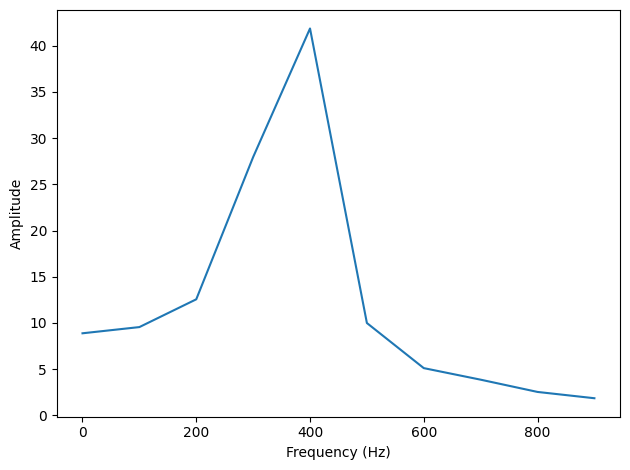

In [8]:
spectrum = segment.make_spectrum()
spectrum.plot(high=1000)
td.decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

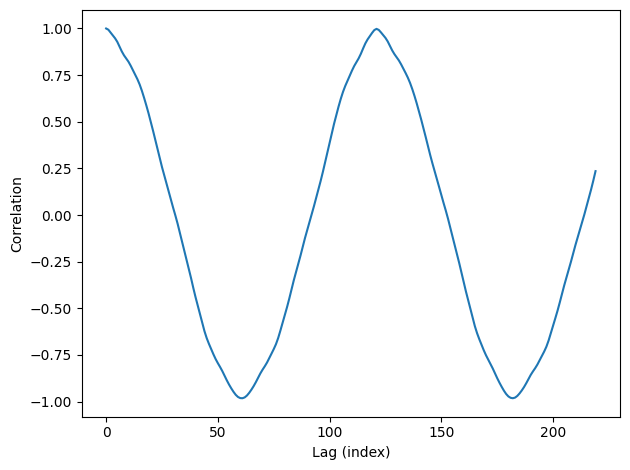

In [9]:
td.plt.plot(lags, corrs)
td.decorate(xlabel='Lag (index)', ylabel='Correlation')

In [10]:
low, high = 110, 130
lag = np.array(corrs[low:high]).argmax() + low
lag

121

In [11]:
period = lag / segment.framerate
frequency = 1 / period
frequency

364.4628099173554

In [12]:
segment.framerate / 120, segment.framerate / 122

(367.5, 361.4754098360656)

# ===================================================================

## Exercise 5.2

The example code in **[chap05.ipynb](../chap05.ipynb)** shows how to use autocorrelation to estimate the fundamental frequency of a periodic signal.

Encapsulate this code in a function called `estimate_fundamental`, and use it to track the pitch of a recorded sound.

To see how well it works, try **superimposing** your pitch estimates on a spectrogram of the recording.

In [13]:
def estimate_fundamental(segment, low=70, high=150):
    corrs = np.correlate(segment.ys, segment.ys, mode='same')
    N = len(corrs)
    lengths = range(N, N//2, -1)

    half = corrs[N//2:].copy()
    half /= lengths
    half /= half[0]

    lag = np.argmax(half[low:high]) + low

    period = lag / segment.framerate
    frequency = 1 / period
    return frequency


In [14]:
""" 
Function on the solution notebook:

def estimate_fundamental(segment, low=70, high=150):
    lags, corrs = autocorr(segment)
    lag = np.array(corrs[low:high]).argmax() + low
    period = lag / segment.framerate
    frequency = 1 / period
    return frequency

    """

' \nFunction on the solution notebook:\n\ndef estimate_fundamental(segment, low=70, high=150):\n    lags, corrs = autocorr(segment)\n    lag = np.array(corrs[low:high]).argmax() + low\n    period = lag / segment.framerate\n    frequency = 1 / period\n    return frequency\n\n    '

364.4628099173554

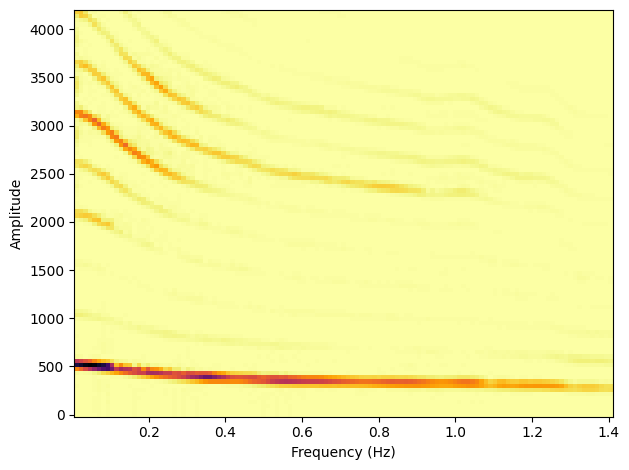

In [15]:
spectogram = wave.make_spectrogram(seg_length=1024)
spectogram.plot(high=4200)
td.decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

duration = 0.01
segment = wave.segment(start=0.5, duration=duration)
freq = estimate_fundamental(segment)
freq


Here's a loop that tracks pitch over the sample.

The `ts` are the mid-points of each segment.

In [16]:
step = 0.05
starts = np.arange(0.0, 1.4, step)
duration = 0.01

ts = []
freqs = []

for start in starts:
    ts.append(start + step/2)
    segment = wave.segment(start=start, duration=duration)
    freq = estimate_fundamental(segment)
    freqs.append(freq)

Here's the pitch-tracking curve superimposed on the spectrogram:

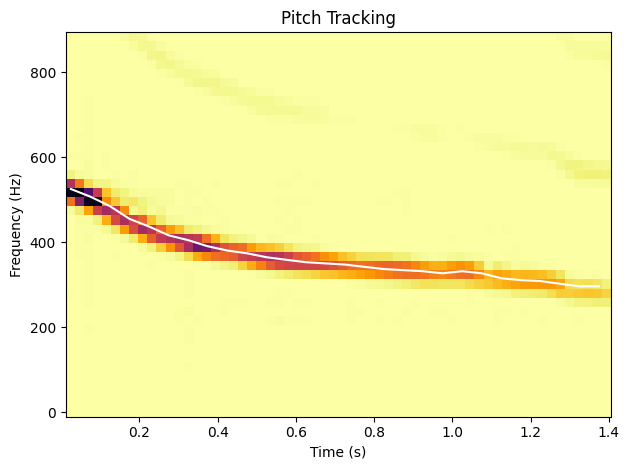

In [17]:
wave.make_spectrogram(seg_length=2048).plot(high=900)
td.plt.plot(ts, freqs, color='white')
td.decorate(xlabel='Time (s)', ylabel='Frequency (Hz)', title='Pitch Tracking')

# ===================================================================

## Exercise 5.3

If you did the exercises in the previous chapter, you downloaded the historical price of BitCoins and estimated the power spectrum of the price changes.

Using the same data, compute the **autocorrelation** of BitCoin prices. Does the autocorrelation function drop off quickly?
Is there evidence of periodic behavior?

In [18]:
if not os.path.exists("../BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv"):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv

In [20]:
import pandas as pd

df = pd.read_csv('../BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv', 
                 parse_dates=[0])

ys = df['Closing Price (USD)']
ts = df.index

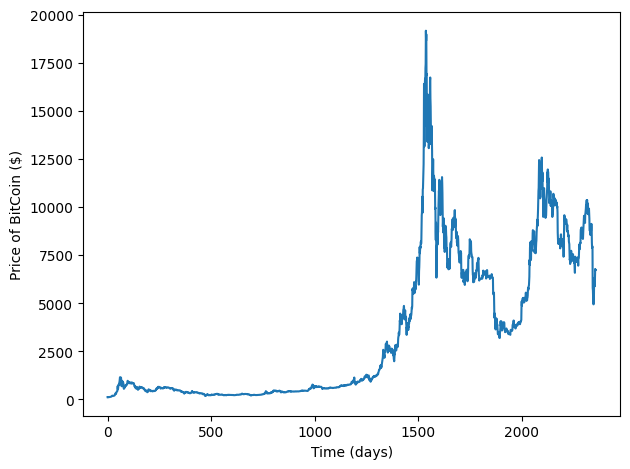

In [22]:
wave = td.Wave(ys, ts, framerate=1)
wave.plot()
td.decorate(xlabel='Time (days)',
         ylabel='Price of BitCoin ($)')

Here's the autocorrelation function using the statistical definition, which unbiases, normalizes, and standardizes; that is, it shifts the mean to zero, divides through by standard deviation, and divides the sum by N.

In [28]:
def serial_corr(wave, lag=1):
    """Computes serial correlation with given lag.

    wave: Wave
    lag: integer, how much to shift the wave

    returns: float correlation coefficient
    """
    n = len(wave)
    y1 = wave.ys[lag:]
    y2 = wave.ys[:n-lag]
    corr_mat = np.corrcoef(y1, y2)
    return corr_mat[0, 1]

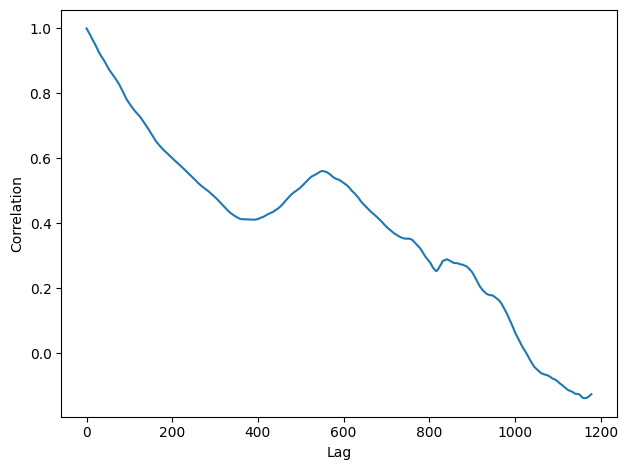

In [29]:
lags, corrs = autocorr(wave)
td.plt.plot(lags, corrs)
td.decorate(xlabel='Lag',
         ylabel='Correlation')

The ACF drops off slowly as lag increases, suggesting some kind of pink noise.

We can compare my implementation of `autocorr` with `np.correlate`, which uses the definition of correlation used in signal processing.  It doesn't unbias, normalize, or standardize the wave.

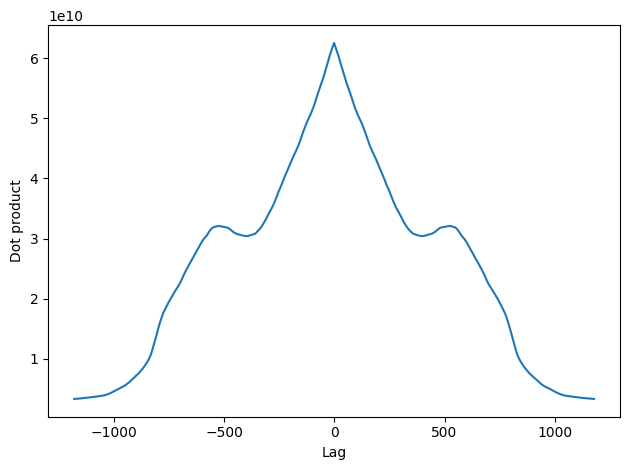

In [30]:
N = len(wave)
corrs2 = np.correlate(wave.ys, wave.ys, mode='same')
lags = np.arange(-N//2, N//2)
td.plt.plot(lags, corrs2)
td.decorate(xlabel='Lag',
         ylabel='Dot product')

The second half of the result corresponds to positive lags:

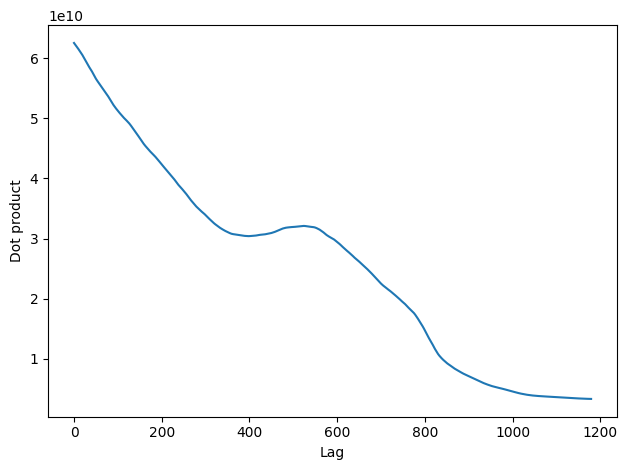

In [31]:
N = len(corrs2)
half = corrs2[N//2:]
td.plt.plot(half)
td.decorate(xlabel='Lag',
         ylabel='Dot product')

We can standardize the results after the fact by dividing through by `lengths`:

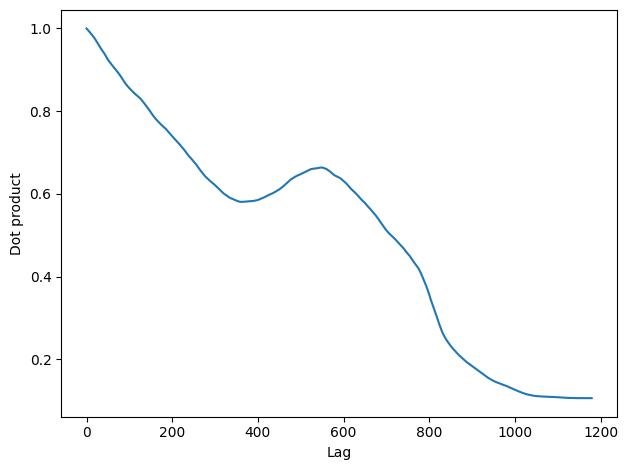

In [32]:
lengths = range(N, N//2, -1)
half /= lengths
half /= half[0]
td.plt.plot(half)
td.decorate(xlabel='Lag',
         ylabel='Dot product')

Now we can compare the two.

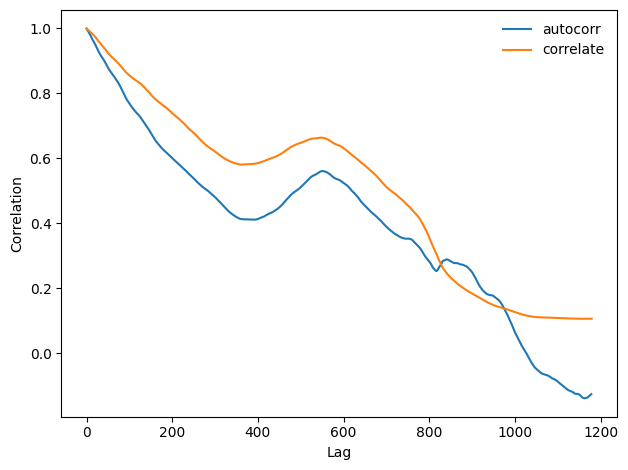

In [33]:
td.plt.plot(corrs, label='autocorr')
td.plt.plot(half, label='correlate')
td.decorate(xlabel='Lag', ylabel='Correlation')

Even after standardizing, the results look substantially different. 

For this dataset, the statistical definition of ACF is probably more appropriate.